In [1]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple, Optional, Union
from tqdm import tqdm
import folium
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import directed_hausdorff
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append('../..')

from ml_mobility_ns3.models.vae import ConditionalTrajectoryVAE
from ml_mobility_ns3.utils.model_utils import load_model_from_checkpoint

# %% Configuration
# Update these paths according to your setup
MODEL_PATH = Path("../results/efficient_run/best_model.pt")
DATA_PATH = Path("../preprocessing/vae_dataset.npz")
PREPROCESSING_DIR = Path("../preprocessing/")

In [2]:
# VAE Model Analysis

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# %% Load Model and Data
def load_vae_model_and_data(model_path, data_path, preprocessing_dir):
    """Load model, data, and all necessary components."""
    print("Loading model...")
    model, config = load_model_from_checkpoint(model_path, device)
    
    print("Loading data...")
    data = np.load(data_path)
    
    print("Loading metadata and scalers...")
    with open(preprocessing_dir / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)
    
    with open(preprocessing_dir / "scalers.pkl", 'rb') as f:
        scalers = pickle.load(f)
    
    return model, data, metadata, scalers

model, data, metadata, scalers = load_vae_model_and_data(MODEL_PATH, DATA_PATH, PREPROCESSING_DIR)

Using device: cpu
Loading model...
Loading data...
Loading metadata and scalers...


In [3]:


# Create transport mode mappings
mode_to_idx = {name: i for i, name in enumerate(metadata['transport_modes'])}
idx_to_mode = {i: name for i, name in enumerate(metadata['transport_modes'])}

print(f"Model architecture: {model.architecture}")
print(f"Transport modes: {metadata['transport_modes']}")
print(f"Sequence length: {metadata['sequence_length']}")

# %% Trajectory Generation Functions
def generate_trajectories(
    model: ConditionalTrajectoryVAE,
    transport_mode: Union[str, int],
    trip_length: int,
    n_samples: int = 1,
    unscale: bool = True
) -> Dict[str, np.ndarray]:
    """Generate trajectories for a given transport mode and length."""
    # Convert mode to index if string
    if isinstance(transport_mode, str):
        mode_idx = mode_to_idx[transport_mode]
    else:
        mode_idx = transport_mode
    
    # Prepare inputs
    mode_tensor = torch.tensor([mode_idx] * n_samples, dtype=torch.long, device=device)
    length_tensor = torch.tensor([trip_length] * n_samples, dtype=torch.long, device=device)
    
    # Generate
    with torch.no_grad():
        generated = model.generate(mode_tensor, length_tensor, n_samples=n_samples, device=device)
    
    generated_np = generated.cpu().numpy()
    
    # Unscale if requested
    if unscale:
        trajectory_scaler = scalers['trajectory']
        unscaled_trajectories = []
        
        for i in range(n_samples):
            # Get valid part
            valid_traj = generated_np[i, :trip_length, :]
            # Unscale
            unscaled = trajectory_scaler.inverse_transform(valid_traj)
            unscaled_trajectories.append(unscaled)
        
        return {
            'scaled': generated_np[:, :trip_length, :],
            'unscaled': np.array(unscaled_trajectories),
            'mode': idx_to_mode[mode_idx],
            'length': trip_length
        }
    else:
        return {
            'scaled': generated_np[:, :trip_length, :],
            'mode': idx_to_mode[mode_idx],
            'length': trip_length
        }

# %% Sampling Functions
def sample_real_trajectories(
    data: Dict[str, np.ndarray],
    transport_mode: Optional[Union[str, int]] = None,
    n_samples: int = 10,
    min_length: Optional[int] = None
) -> List[Dict[str, np.ndarray]]:
    """Sample real trajectories from the dataset."""
    trajectories = data['trajectories']
    masks = data['masks']
    modes = data['transport_modes']
    lengths = data['trip_lengths']
    
    # Filter by mode if specified
    if transport_mode is not None:
        if isinstance(transport_mode, str):
            mode_idx = mode_to_idx[transport_mode]
        else:
            mode_idx = transport_mode
        valid_indices = np.where(modes == mode_idx)[0]
    else:
        valid_indices = np.arange(len(trajectories))
    
    # Filter by minimum length if specified
    if min_length is not None:
        length_mask = lengths[valid_indices] >= min_length
        valid_indices = valid_indices[length_mask]
    
    # Sample
    if len(valid_indices) < n_samples:
        print(f"Warning: Only {len(valid_indices)} trajectories available, sampling with replacement")
        sample_indices = np.random.choice(valid_indices, n_samples, replace=True)
    else:
        sample_indices = np.random.choice(valid_indices, n_samples, replace=False)
    
    # Extract samples
    samples = []
    trajectory_scaler = scalers['trajectory']
    
    for idx in sample_indices:
        length = int(lengths[idx])
        scaled_traj = trajectories[idx, :length, :]
        unscaled_traj = trajectory_scaler.inverse_transform(scaled_traj)
        
        samples.append({
            'scaled': scaled_traj,
            'unscaled': unscaled_traj,
            'mode': idx_to_mode[modes[idx]],
            'length': length,
            'index': idx
        })
    
    return samples

# %% Reconstruction Functions
def reconstruct_trajectories(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    indices: Union[int, List[int]],
    return_latent: bool = False
) -> List[Dict[str, np.ndarray]]:
    """Reconstruct trajectories through the VAE."""
    # Always ensure indices is a list
    if isinstance(indices, (int, np.integer)):
        indices = [int(indices)]
    elif isinstance(indices, np.ndarray):
        indices = indices.tolist()
    
    results = []
    trajectory_scaler = scalers['trajectory']
    
    for idx in indices:
        idx = int(idx)
        
        # Get original data
        traj = torch.tensor(data['trajectories'][idx:idx+1], dtype=torch.float32, device=device)
        mask = torch.tensor(data['masks'][idx:idx+1], dtype=torch.bool, device=device)
        mode = torch.tensor([data['transport_modes'][idx]], dtype=torch.long, device=device)
        length = torch.tensor([data['trip_lengths'][idx]], dtype=torch.long, device=device)
        
        # Reconstruct
        with torch.no_grad():
            recon, mu, logvar = model(traj, mode, length, mask)
            
        # Extract valid part
        valid_length = int(length.item())
        original_scaled = traj[0, :valid_length].cpu().numpy()
        recon_scaled = recon[0, :valid_length].cpu().numpy()
        
        # Unscale
        original_unscaled = trajectory_scaler.inverse_transform(original_scaled)
        recon_unscaled = trajectory_scaler.inverse_transform(recon_scaled)
        
        result = {
            'original_scaled': original_scaled,
            'original_unscaled': original_unscaled,
            'reconstructed_scaled': recon_scaled,
            'reconstructed_unscaled': recon_unscaled,
            'mode': idx_to_mode[data['transport_modes'][idx]],
            'length': valid_length,
            'index': idx
        }
        
        if return_latent:
            result['latent_mu'] = mu.cpu().numpy()
            result['latent_logvar'] = logvar.cpu().numpy()
        
        results.append(result)
    
    return results

Model architecture: lstm
Transport modes: ['BIKE', 'BUS', 'ELECT_BIKE', 'ELECT_SCOOTER', 'LIGHT_COMM_VEHICLE', 'ON_DEMAND', 'OTHER', 'PLANE', 'PRIV_CAR_DRIVER', 'PRIV_CAR_PASSENGER', 'SUBWAY', 'TAXI', 'TRAIN', 'TRAIN_EXPRESS', 'TRAMWAY', 'TWO_WHEELER', 'WALKING', 'mixed']
Sequence length: 2070


In [4]:

# %% Error Computation Functions
def compute_reconstruction_error(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    n_samples: Optional[int] = None,
    by_mode: bool = True
) -> Dict[str, float]:
    """Compute reconstruction errors."""
    n_total = len(data['trajectories'])
    if n_samples is None:
        n_samples = n_total
    else:
        n_samples = min(n_samples, n_total)
    
    # Sample indices
    indices = np.random.choice(n_total, n_samples, replace=False)
    
    errors_by_mode = {mode: [] for mode in metadata['transport_modes']}
    all_errors = []
    
    for idx in tqdm(indices, desc="Computing reconstruction errors"):
        # Reconstruct
        recon = reconstruct_trajectories(model, data, idx)[0]
        
        # Compute error (MSE on unscaled data)
        error = mean_squared_error(
            recon['original_unscaled'],
            recon['reconstructed_unscaled']
        )
        
        mode = recon['mode']
        errors_by_mode[mode].append(error)
        all_errors.append(error)
    
    # Compute statistics
    results = {
        'overall_mse': np.mean(all_errors),
        'overall_rmse': np.sqrt(np.mean(all_errors)),
        'overall_std': np.std(all_errors)
    }
    
    if by_mode:
        for mode in metadata['transport_modes']:
            if errors_by_mode[mode]:
                results[f'{mode}_mse'] = np.mean(errors_by_mode[mode])
                results[f'{mode}_rmse'] = np.sqrt(np.mean(errors_by_mode[mode]))
                results[f'{mode}_count'] = len(errors_by_mode[mode])
    
    return results

# %% Visualization Functions
def plot_trajectories(
    trajectories: Union[Dict, List[Dict]],
    title: str = "Trajectories",
    figsize: Tuple[int, int] = (12, 8),
    show_speed: bool = True
) -> plt.Figure:
    """Plot trajectories with multiple subplots."""
    if isinstance(trajectories, dict):
        trajectories = [trajectories]
    
    n_traj = len(trajectories)
    
    if show_speed:
        fig, axes = plt.subplots(n_traj, 2, figsize=figsize)
        if n_traj == 1:
            axes = axes.reshape(1, -1)
    else:
        fig, axes = plt.subplots(n_traj, 1, figsize=figsize)
        if n_traj == 1:
            axes = [axes]
    
    for i, traj in enumerate(trajectories):
        # Use unscaled data if available
        if 'unscaled' in traj:
            data = traj['unscaled']
        else:
            data = traj['original_unscaled']
        
        # Plot trajectory
        if show_speed:
            ax = axes[i, 0]
        else:
            ax = axes[i]
            
        ax.plot(data[:, 1], data[:, 0], 'b-', alpha=0.7, linewidth=1)
        ax.plot(data[0, 1], data[0, 0], 'go', markersize=8, label='Start')
        ax.plot(data[-1, 1], data[-1, 0], 'ro', markersize=8, label='End')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f"{traj.get('mode', 'Unknown')} - Length: {traj.get('length', len(data))}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot speed profile if requested
        if show_speed:
            ax_speed = axes[i, 1]
            time_points = np.arange(len(data)) * 2  # 2 seconds intervals
            ax_speed.plot(time_points, data[:, 2], 'b-', alpha=0.7)
            ax_speed.set_xlabel('Time (seconds)')
            ax_speed.set_ylabel('Speed (m/s)')
            ax_speed.set_title('Speed Profile')
            ax_speed.grid(True, alpha=0.3)
            
            # Add speed statistics
            speed_stats = f"Mean: {np.mean(data[:, 2]):.1f} m/s\nMax: {np.max(data[:, 2]):.1f} m/s"
            ax_speed.text(0.95, 0.95, speed_stats, transform=ax_speed.transAxes,
                         verticalalignment='top', horizontalalignment='right',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

def create_interactive_map(
    trajectories: Union[Dict, List[Dict]],
    center: Optional[Tuple[float, float]] = None,
    zoom_start: int = 12
) -> folium.Map:
    """Create interactive Folium map with trajectories."""
    if isinstance(trajectories, dict):
        trajectories = [trajectories]
    
    # Calculate center if not provided
    if center is None:
        all_lats = []
        all_lons = []
        for traj in trajectories:
            if 'unscaled' in traj:
                data = traj['unscaled']
            else:
                data = traj['original_unscaled']
            all_lats.extend(data[:, 0])
            all_lons.extend(data[:, 1])
        center = (np.mean(all_lats), np.mean(all_lons))
    
    # Create map
    m = folium.Map(location=center, zoom_start=zoom_start)
    
    # Color palette
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkred', 
              'lightblue', 'darkgreen', 'pink', 'gray']
    
    for i, traj in enumerate(trajectories):
        if 'unscaled' in traj:
            data = traj['unscaled']
        else:
            data = traj['original_unscaled']
        
        points = [(lat, lon) for lat, lon in data[:, :2]]
        color = colors[i % len(colors)]
        
        # Add trajectory line
        folium.PolyLine(
            points,
            color=color,
            weight=3,
            opacity=0.8,
            popup=f"{traj.get('mode', 'Unknown')} - {traj.get('length', len(data))} points"
        ).add_to(m)
        
        # Add markers
        folium.CircleMarker(
            points[0],
            radius=6,
            color='green',
            fill=True,
            fillColor='green',
            fillOpacity=0.8,
            popup=f"Start - {traj.get('mode', 'Unknown')}"
        ).add_to(m)
        
        folium.CircleMarker(
            points[-1],
            radius=6,
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.8,
            popup=f"End - {traj.get('mode', 'Unknown')}"
        ).add_to(m)
    
    return m


In [5]:

# %% Analysis Pipeline
def run_complete_analysis(model, data, metadata, scalers, n_samples_per_mode=5):
    """Run complete analysis pipeline."""
    print("=== VAE Model Analysis ===\n")
    
    # 1. Model Information
    print("1. Model Information")
    print(f"   Architecture: {model.architecture}")
    print(f"   Latent dimension: {model.latent_dim}")
    print(f"   Hidden dimension: {model.hidden_dim}")
    print(f"   Transport modes: {metadata['transport_modes']}")
    print()
    
    # 2. Dataset Statistics
    print("2. Dataset Statistics")
    mode_counts = np.bincount(data['transport_modes'])
    for i, mode in enumerate(metadata['transport_modes']):
        if i < len(mode_counts):
            print(f"   {mode}: {mode_counts[i]} trips ({mode_counts[i]/len(data['transport_modes'])*100:.1f}%)")
    print()
    
    # 3. Reconstruction Error
    print("3. Computing Reconstruction Errors...")
    errors = compute_reconstruction_error(model, data, n_samples=min(1000, len(data['trajectories'])))
    print(f"   Overall RMSE: {errors['overall_rmse']:.4f}")
    for mode in metadata['transport_modes']:
        if f'{mode}_rmse' in errors:
            print(f"   {mode} RMSE: {errors[f'{mode}_rmse']:.4f} (n={errors[f'{mode}_count']})")
    print()
    
    # 4. Generate Samples
    print("4. Generating Sample Trajectories...")
    generated_samples = {}
    real_samples = {}
    
    for mode in metadata['transport_modes']:
        # Sample real trajectories
        real = sample_real_trajectories(data, transport_mode=mode, n_samples=n_samples_per_mode)
        if real:
            real_samples[mode] = real
            
            # Generate with similar lengths
            avg_length = int(np.mean([t['length'] for t in real]))
            gen = generate_trajectories(model, mode, avg_length, n_samples=n_samples_per_mode)
            generated_samples[mode] = [gen]  # Wrap in list for consistency
    
    # 5. Compare Statistics
    print("\n5. Comparing Real vs Generated Trajectories...")
    all_real = [traj for mode_trajs in real_samples.values() for traj in mode_trajs]
    all_generated = [traj for mode_trajs in generated_samples.values() for traj in mode_trajs]
    
    comparison_df = compare_real_vs_generated(all_real, all_generated)
    
    # Print summary statistics
    print("\nSpeed Statistics by Mode:")
    summary = comparison_df.groupby(['type', 'mode'])['speed_mean'].agg(['mean', 'std']).round(2)
    print(summary)
    
    print("\nDistance Statistics by Mode:")
    distance_summary = comparison_df.groupby(['type', 'mode'])['total_distance_m'].agg(['mean', 'std']).round(2)
    print(distance_summary)
    
    return {
        'errors': errors,
        'comparison_df': comparison_df,
        'real_samples': real_samples,
        'generated_samples': generated_samples
    }

In [6]:
# %% Comparison Functions
def compare_real_vs_generated(
    real_trajectories: List[Dict],
    generated_trajectories: List[Dict],
    metrics: List[str] = ['distance', 'speed', 'direction']
) -> pd.DataFrame:
    """Compare statistics between real and generated trajectories."""
    results = []
    
    for traj_type, trajectories in [('Real', real_trajectories), ('Generated', generated_trajectories)]:
        for traj in trajectories:
            if 'unscaled' in traj:
                data = traj['unscaled']
            else:
                data = traj['original_unscaled']
            
            # Calculate metrics
            stats = {
                'type': traj_type,
                'mode': traj.get('mode', 'Unknown'),
                'length': len(data)
            }
            
            if 'distance' in metrics:
                # Calculate total distance
                diffs = np.diff(data[:, :2], axis=0)
                distances = np.sqrt(np.sum(diffs**2, axis=1)) * 111000  # Convert to meters (approx)
                stats['total_distance_m'] = np.sum(distances)
                stats['avg_step_distance_m'] = np.mean(distances)
            
            if 'speed' in metrics:
                speeds = data[:, 2]
                stats['speed_mean'] = np.mean(speeds)
                stats['speed_std'] = np.std(speeds)
                stats['speed_max'] = np.max(speeds)
                stats['speed_q25'] = np.percentile(speeds, 25)
                stats['speed_q50'] = np.percentile(speeds, 50)
                stats['speed_q75'] = np.percentile(speeds, 75)
            
            if 'direction' in metrics:
                # Calculate main direction
                start_point = data[0, :2]
                end_point = data[-1, :2]
                direction_vector = end_point - start_point
                angle = np.arctan2(direction_vector[1], direction_vector[0]) * 180 / np.pi
                stats['main_direction_deg'] = angle
                stats['displacement_m'] = np.sqrt(np.sum(direction_vector**2)) * 111000
            
            results.append(stats)
    
    return pd.DataFrame(results)

def compute_trajectory_similarity(traj1: np.ndarray, traj2: np.ndarray) -> Dict[str, float]:
    """Compute similarity metrics between two trajectories."""
    # Ensure same length for comparison
    min_len = min(len(traj1), len(traj2))
    traj1 = traj1[:min_len]
    traj2 = traj2[:min_len]
    
    # Spatial similarity (Hausdorff distance)
    hausdorff_dist = max(
        directed_hausdorff(traj1[:, :2], traj2[:, :2])[0],
        directed_hausdorff(traj2[:, :2], traj1[:, :2])[0]
    )
    
    # Speed similarity
    speed_mse = mean_squared_error(traj1[:, 2], traj2[:, 2])
    speed_corr = np.corrcoef(traj1[:, 2], traj2[:, 2])[0, 1]
    
    return {
        'hausdorff_distance': hausdorff_dist,
        'speed_mse': speed_mse,
        'speed_correlation': speed_corr
    }


In [7]:

# %% Fixed Error Computation Function
def compute_reconstruction_error(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    n_samples: int = 1000,
    by_mode: bool = True,
    batch_size: int = 64
) -> Dict[str, float]:
    """
    Compute reconstruction error on a dataset.
    
    Args:
        model: Trained VAE model
        data: Dictionary containing trajectories, masks, transport_modes, trip_lengths
        n_samples: Number of samples to evaluate (if less than total, will sample randomly)
        by_mode: Whether to compute per-mode statistics
        batch_size: Batch size for processing
        
    Returns:
        Dictionary with reconstruction metrics
    """
    model.eval()
    
    # Sample indices if needed
    total_samples = len(data['trajectories'])
    if n_samples < total_samples:
        indices = np.random.choice(total_samples, n_samples, replace=False)
        trajectories = data['trajectories'][indices]
        masks = data['masks'][indices]
        transport_modes = data['transport_modes'][indices]
        trip_lengths = data['trip_lengths'][indices]
    else:
        trajectories = data['trajectories']
        masks = data['masks']
        transport_modes = data['transport_modes']
        trip_lengths = data['trip_lengths']
        n_samples = total_samples
    
    total_recon_error = 0
    total_valid_points = 0
    mode_errors = {mode: [] for mode in metadata['transport_modes']} if by_mode else {}
    mode_points = {mode: 0 for mode in metadata['transport_modes']} if by_mode else {}
    
    for i in tqdm(range(0, n_samples, batch_size), desc="Computing reconstruction errors"):
        batch_end = min(i + batch_size, n_samples)
        
        # Get batch
        batch_traj = torch.tensor(trajectories[i:batch_end], dtype=torch.float32).to(device)
        batch_mask = torch.tensor(masks[i:batch_end], dtype=torch.bool).to(device)
        batch_modes = torch.tensor(transport_modes[i:batch_end], dtype=torch.long).to(device)
        batch_lengths = torch.tensor(trip_lengths[i:batch_end], dtype=torch.long).to(device)
        
        with torch.no_grad():
            # Reconstruct
            recon, _, _ = model(batch_traj, batch_modes, batch_lengths, batch_mask)
            
            # Compute masked error
            diff = (recon - batch_traj) ** 2
            mask_expanded = batch_mask.unsqueeze(-1).expand_as(diff)
            masked_diff = diff * mask_expanded
            
            total_recon_error += masked_diff.sum().item()
            total_valid_points += mask_expanded.sum().item()
            
            # Per-mode statistics
            if by_mode:
                for j, mode_idx in enumerate(batch_modes.cpu().numpy()):
                    mode_name = idx_to_mode[mode_idx]
                    sample_mask = mask_expanded[j]
                    sample_error = masked_diff[j][sample_mask].sum().item()
                    sample_points = sample_mask.sum().item()
                    
                    if sample_points > 0:
                        mode_errors[mode_name].append(sample_error / sample_points)
                        mode_points[mode_name] += sample_points
    
    mean_recon_error = total_recon_error / (total_valid_points + 1e-8)
    
    results = {
        'overall_rmse': np.sqrt(mean_recon_error),
        'overall_mse': mean_recon_error,
        'total_valid_points': total_valid_points,
        'n_samples': n_samples
    }
    
    if by_mode:
        for mode, errors in mode_errors.items():
            if errors:
                results[f'{mode}_rmse'] = np.sqrt(np.mean(errors))
                results[f'{mode}_mse'] = np.mean(errors)
                results[f'{mode}_n_samples'] = len(errors)
                results[f'{mode}_points'] = mode_points[mode]
    
    return results


In [11]:
# 1. Generate trajectories for different modes
print("1. Generating trajectories for different transport modes...")
generated_examples = {}
for mode in ['PRIV_CAR_PASSENGER', 'WALK', 'BIKE']:
    if mode in mode_to_idx:
        gen = generate_trajectories(model, mode, trip_length=500, n_samples=3)
        generated_examples[mode] = gen
        print(f"   Generated {len(gen['unscaled'])} {mode} trajectories")

# 2. Sample and reconstruct real trajectories
print("\n2. Sampling and reconstructing real trajectories...")
real_samples = sample_real_trajectories(data, transport_mode='PRIV_CAR_PASSENGER', n_samples=5)
reconstructions = reconstruct_trajectories(model, data, [s['index'] for s in real_samples])

# 3. Plot examples
print("\n3. Creating visualizations...")


1. Generating trajectories for different transport modes...
   Generated 3 PRIV_CAR_PASSENGER trajectories
   Generated 3 BIKE trajectories

2. Sampling and reconstructing real trajectories...

3. Creating visualizations...


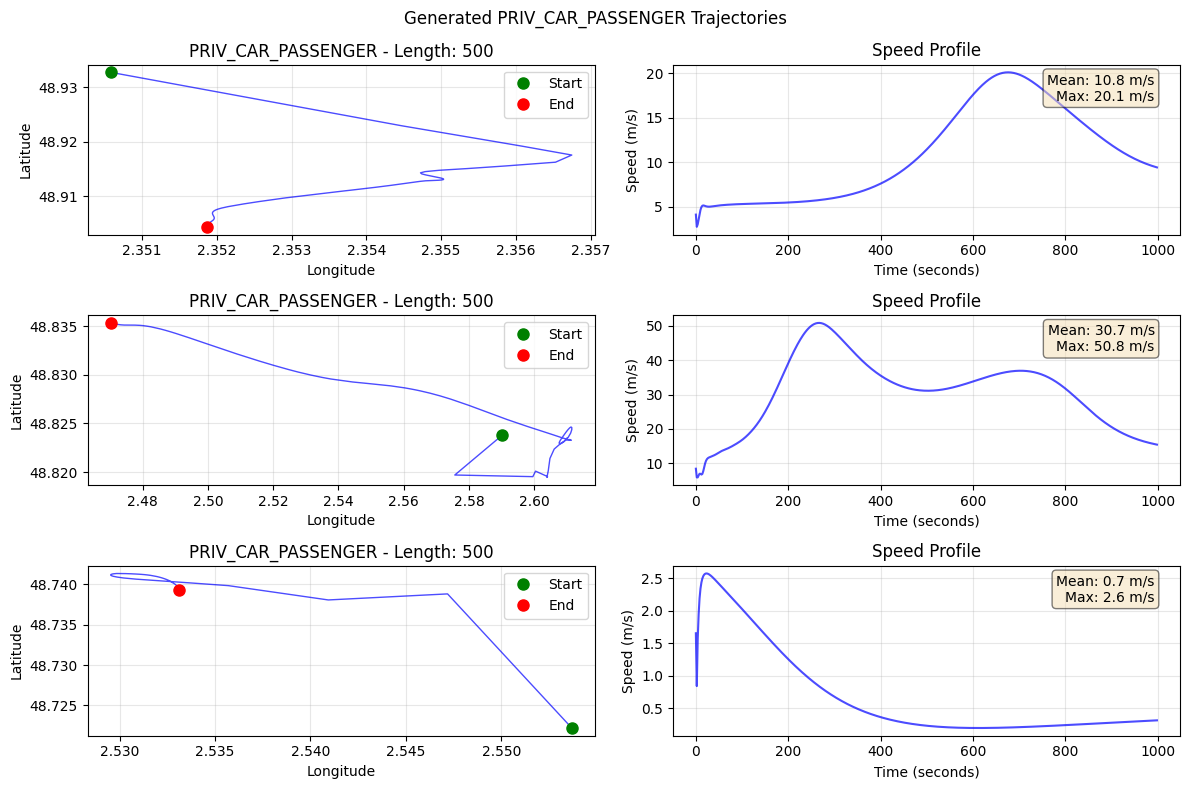

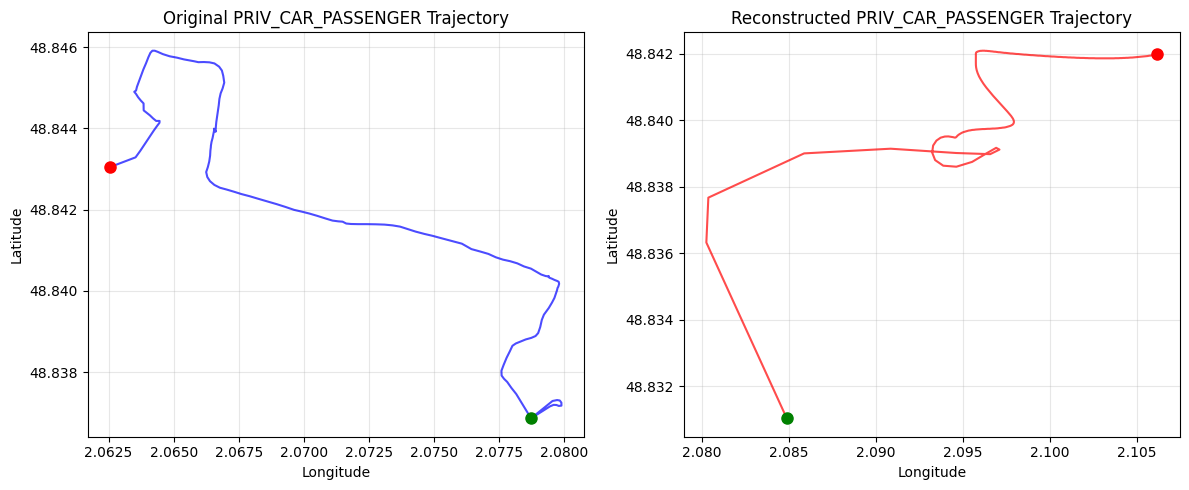

In [12]:

# Plot generated trajectories
if generated_examples:
    mode = list(generated_examples.keys())[0]
    gen_data = generated_examples[mode]
    
    # Convert to list of dicts for plotting
    plot_data = []
    for i in range(len(gen_data['unscaled'])):
        plot_data.append({
            'unscaled': gen_data['unscaled'][i],
            'mode': gen_data['mode'],
            'length': gen_data['length']
        })
    
    fig = plot_trajectories(plot_data[:3], title=f"Generated {mode} Trajectories")
    plt.show()

# Plot reconstruction comparison
if reconstructions:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    recon = reconstructions[0]
    
    # Original
    ax = axes[0]
    orig = recon['original_unscaled']
    ax.plot(orig[:, 1], orig[:, 0], 'b-', alpha=0.7, label='Original')
    ax.plot(orig[0, 1], orig[0, 0], 'go', markersize=8)
    ax.plot(orig[-1, 1], orig[-1, 0], 'ro', markersize=8)
    ax.set_title(f"Original {recon['mode']} Trajectory")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    
    # Reconstructed
    ax = axes[1]
    recon_traj = recon['reconstructed_unscaled']
    ax.plot(recon_traj[:, 1], recon_traj[:, 0], 'r-', alpha=0.7, label='Reconstructed')
    ax.plot(recon_traj[0, 1], recon_traj[0, 0], 'go', markersize=8)
    ax.plot(recon_traj[-1, 1], recon_traj[-1, 0], 'ro', markersize=8)
    ax.set_title(f"Reconstructed {recon['mode']} Trajectory")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()